cuda
Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/extra_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat
Number of output:  10
Number of labeled data:  5000
Number of unlabeled data:  114289
Number of unlabeled data batch:  114
Number of task:  5
Number of labeled data per task:  1000
Number of unlabeled data per task:  13000
Number of unlabeled data batch per task:  13
Number of unlabeled data test:  5000
0
	Epoch 1 complete! 	Training Loss:  2114.8912723214285
	Epoch 2 complete! 	Training Loss:  2041.3572723214286
	Epoch 3 complete! 	Training Loss:  2033.3232633928571
	Epoch 4 complete! 	Training Loss:  2027.055185267857
	Epoch 5 complete! 	Training Loss:  2014.3034776785714
	Epoch 6 complete! 	Training Loss:  2003.8388325892856
	Epoch 7 complete! 	Training Loss:  1993.8169263392856
	Epoch 8 complete! 	Training Loss:  1989.3333191964286
	Epoch 9 complete! 	Training Loss:  1983.7081763392857
	Ep

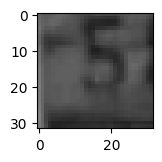

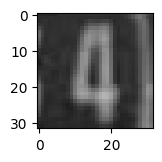

In [1]:
from utilsADCN1 import svhnLoader, plotPerformance
import numpy as np
import pdb
import torch
import random
from torchvision import datasets, transforms
import pickle

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.autograd.variable import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
num_workers = 0
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time
import warnings
warnings.filterwarnings('ignore')

# import vae
import svhn_vae1
from sklearn.metrics import classification_report
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix

import gc
torch.cuda.empty_cache()

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


seed = 54 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False

start = time.time()

transform=transforms.Compose([
                            transforms.ToTensor(),
                         transforms.Grayscale(),                      

                     ])
unlabeledData = datasets.SVHN(root='./data/svhn', split='train', download=True,
                                        transform=transform)
extra = datasets.SVHN(root='./data/svhn', split='extra', download=True,
                                        transform=transform)
labeledData = datasets.SVHN(root='./data/svhn', split='test', download=True,
                                        transform=transform)


ex_svhn,unused = random_split(extra,[20000,len(extra)-20000])
svhnData = torch.utils.data.ConcatDataset((unlabeledData,ex_svhn))


## Generate the datastream
dataStream = svhnLoader(labeledData, svhnData, nEachClassSamples = 500)


dataStream.createTask(nTask = 5, taskList = [[0,1],[2,3],[4,5],[6,7],[8,9]], taskType = 3)

X = torch.transpose(dataStream.unlabeledData[2],1,2)
X = torch.transpose(X,2,3)
plt.figure(figsize= (1.5, 1.5))
plt.imshow(X[5
            ])

### Dataloader for different tasks
def trn_loader(task_id,batch_size):
  # task_id = 0
  x_samples = dataStream.unlabeledData[task_id].to(torch.float32)
#   x_samples = F.adjust_sharpness(x_samples, 5.0)
  y_samples = dataStream.unlabeledLabel[task_id].to(torch.uint8)

  train_data = TensorDataset(x_samples,y_samples)
  train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)

  return train_loader, train_data


def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    # print(confusion_matrix(ytrue, ypred))
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM



def s_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    w_loss = x.mean() -x_hat.mean() #mean(x,x_hat) # K.mean(y_true * y_pred)
    beta = 1.5

    return reproduction_loss + beta*KLD + w_loss

def vae_train(train_loader, model,optimzr,epochs,batchSize,x_dim):
  # Training

  model.train()
  for epoch in range(epochs):
      train_loss = 0
      for batch_idx, (x, _) in enumerate(train_loader):
          x = x.view(batchSize, x_dim)
          x = x.to(DEVICE)
          x_hat, mean, log_var = model(x)
          loss = s_loss_function(x, x_hat, mean, log_var)

          train_loss += loss.item()
          loss.backward()
          optimzr.step()
          optimzr.zero_grad()
      print("\tEpoch", epoch + 1, "complete!", "\tTraining Loss: ", train_loss / (batch_idx*batchSize),)
  return model

def asgn_clust_labl(km, tr_lbls):
    asgn_lbls = {}
#     print(km)

    for i in range(km.n_clusters):

        lbls = []
        idx = np.where(km.labels_ == i)
        if (len(idx[0]) > 0):
            lbls.append(tr_lbls[idx])
            if (len(lbls[0]) == 1):   
                cnts = np.bincount(lbls[0])
            else:
                cnts = np.bincount(np.squeeze(lbls))

#             print(i, cnts)
            if np.argmax(cnts) in asgn_lbls:
#                 print(i)
                asgn_lbls[np.argmax(cnts)].append(i)
            else:
#                 print(i)
                asgn_lbls[np.argmax(cnts)] = [i]

    return asgn_lbls

def data_lbls(X_lbls, clust_lbls,tsk_id):

    p_lbls = np.ones(len(X_lbls)).astype(np.uint8)*2*tsk_id

    for i, clus in enumerate(X_lbls):
        for key,value in clust_lbls.items():
#             print(key,value)
            if clus in value:
                p_lbls[i] = key

    return p_lbls


def latent_data(trn_load_ful,model,x_dim):
  for batch_idx, (x_ful, y_ful) in enumerate(trn_load_ful):
    x_ful = x_ful.to(DEVICE)
    y_ful = y_ful.to(DEVICE)
  x_ful = x_ful.view(x_ful.shape[0], x_dim)
  print(x_ful.shape)

  model.eval()
  x_out, z_mean_vae, _ = model(x_ful)
  return x_ful, y_ful, x_out, z_mean_vae


#### Structure of data capturing
def structure_data(real_data):

  P_cov = torch.cov(real_data, correction=0)
  D, V = torch.linalg.eigh(P_cov)
  idx = torch.argsort(D, dim=0,descending = True)
  d = D[idx]
  V = V[:,idx]
   
  return d, V

X = torch.transpose(dataStream.unlabeledData[2],1,2)
X = torch.transpose(X,2,3)
plt.figure(figsize= (1.5, 1.5))
plt.imshow(X[7554])

## Expert Training
task_id = 0
# VAE Model Hyperparameters
#batch_size = 100
inputdim = dataStream.unlabeledData[0].shape[1]*dataStream.unlabeledData[0].shape[2]*dataStream.unlabeledData[0].shape[3]
hidden_dim1 = 1500
hidden_dim2 = 700
latent_dim = [128,128, 128,128,128]
lr = 1e-4 # [1e-4,1e-4,1e-4,1e-4,1e-4]
s_encoder = svhn_vae1.Encoder(input_dim =inputdim , hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, latent_dim=latent_dim[task_id])
s_decoder = svhn_vae1.Decoder(latent_dim=latent_dim[task_id], hidden_dim1=hidden_dim1,hidden_dim2=hidden_dim2, output_dim=inputdim)
s_task_model = svhn_vae1.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)
optimizer_VAE = Adam(s_task_model.parameters(), lr=lr)
batchsize = 500 #300 #200 #ataStream.batchSize
task_clust_lbls = {}
epch = [350, 350 , 350, 350 , 350]

cnt = 0

for task_id in range(5):

  print(task_id)
  data_loader, trn_data = trn_loader(task_id, batchsize)

  s_task_model = vae_train(data_loader,s_task_model,optimizer_VAE ,epch[task_id],batchsize,inputdim)
  torch.save(s_task_model.state_dict(),'s_task'+str(task_id)+'_model')


  for i in range(1):
    (x_lbl,y_lbl) = next(iter(data_loader))

  x_lbl = x_lbl.view(batchsize, inputdim)
  s_task_model.eval()
  _,z_lbl,_ = s_task_model(x_lbl.to(DEVICE))

  # dataStream.unlabeledData[0].shape[0]
  train_loader_ful = DataLoader(dataset=trn_data, batch_size=10000, shuffle=True, drop_last=True, num_workers=num_workers)
  x_ful, y_ful, x_out, z_mean_vae = latent_data(train_loader_ful,s_task_model,inputdim)

  X = z_mean_vae.cpu().detach().numpy()

  clust_lbl =  torch.unique(y_lbl).detach().numpy()
  n_clust = len(clust_lbl)

  if task_id ==0 :
    z_mn = {} 
    z_EVal = {} 
    z_EVec = {}
  
  kmeans = MiniBatchKMeans(n_clusters= 325, random_state=3, init = 'k-means++', n_init="auto", max_iter=15000, tol=0.00002,  ).fit(z_lbl.cpu().detach().numpy())

  clus_lbls = asgn_clust_labl(kmeans, y_lbl.detach().numpy())
  task_clust_lbls[task_id] = clus_lbls

  for i in range(n_clust):
    zxmean =  torch.mean(z_lbl[y_lbl == clust_lbl[i]],0)
    eVal, eVec = structure_data(z_lbl[y_lbl == clust_lbl[i]].T)
    # if task_id == 0:
    z_mn[task_id*n_clust+i] = zxmean
    z_EVal[task_id*n_clust+i] = eVal
    z_EVec[task_id*n_clust+i] = eVec
  
  if task_id == 0:
    # tmodel0 = task_model
    filename = 'Spl0_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 1:
    # tmodel1 = task_model
    filename = 'Spl1_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 2:
    # tmodel2 = task_model
    filename = 'Spl2_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 3:
    # tmodel3 = task_model
    filename = 'Spl3_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))
  elif task_id == 4:
    # tmodel5 = task_model
    filename = 'Spl4_clust_model.sav'
    pickle.dump(kmeans, open(filename, 'wb'))



In [2]:
tsk_count = 5
arr_cnt = len(z_mn)

sample_size = 700 # Sample size for the structured data

struct_samp_arr = torch.zeros((arr_cnt*sample_size,dataStream.unlabeledData[0][1].shape[0],
                               dataStream.unlabeledData[0][1].shape[1],dataStream.unlabeledData[0][1].shape[2]))
tsk_arr = torch.zeros((arr_cnt*sample_size))

### Structured data generation

for n_cnt in range(len(z_mn)):
  s_encoder = svhn_vae1.Encoder(input_dim =inputdim , hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2,latent_dim=latent_dim[n_cnt//2])
  s_decoder = svhn_vae1.Decoder(latent_dim=latent_dim[n_cnt//2],hidden_dim1=hidden_dim1,hidden_dim2=hidden_dim2, output_dim=inputdim)
  savd_model = svhn_vae1.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)

  std_vec = torch.randn(sample_size, latent_dim[n_cnt//2]).to(DEVICE) #torch.empty(sample_size, latent_dim).normal_(mean=0,std=1.0) #
  a_vec = torch.mul(std_vec,z_EVal[n_cnt])
  a_vec = torch.matmul(z_EVec[n_cnt],a_vec.T).T+z_mn[n_cnt][None,:]

  savd_model.load_state_dict(torch.load('s_task'+str(n_cnt//2)+'_model'))
  savd_model = savd_model.to(DEVICE)
  struct_samp_arr[(sample_size)*(n_cnt):(sample_size)*(n_cnt+1),:,:,:] = (savd_model.Decoder(a_vec)).view(-1,3,32,32)
  tsk_arr[n_cnt*sample_size:(n_cnt+1)*sample_size] = n_cnt//2


ta_dataset = TensorDataset(struct_samp_arr,tsk_arr)


# In[32]:


In [3]:
struct_samp_arr.shape

torch.Size([7000, 3, 32, 32])

In [4]:

# Divide the structured dataset into gTrain and gVal
gTrain, gValid = random_split(ta_dataset,[6000,1000])
gbatch = 50 #100(52.p)
gtrain_loader = DataLoader(dataset=gTrain, batch_size=gbatch, shuffle=True, drop_last=True, num_workers=num_workers)
gvalid_loader = DataLoader(dataset=gValid, batch_size=1000, shuffle=True, drop_last=True, num_workers=num_workers)


# In[33]:


class Guide(nn.Module):


    def __init__(self, n_task):

        super(Guide, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.Linear(1024, 128),
            # nn.ReLU(inplace=True),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_task),
            nn.LeakyReLU(0.1,inplace=True),
            # nn.GELU(),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
       
        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

ta_model = Guide(n_task = dataStream.nTask)

ta_model.to(DEVICE)

learning_rate = 0.0001  #0.000016 #0.0000001

ta_optimizer = torch.optim.RMSprop(ta_model.parameters(), lr=learning_rate)
ta_criterion = nn.CrossEntropyLoss().to(DEVICE)

epochs = 30
for epoch in range(epochs):
  ta_model.train()
  clf_error = 0.0
  clf_valid_error = 0.0
  for batch_idx, (x_in,labels) in enumerate(gtrain_loader):
    
    x_in  = x_in.to(DEVICE)
    x_in = x_in.to(torch.float32)
    #labels = labels.view(batch_size_CLF, 1)
    labels  = labels.to(torch.long)#.to(DEVICE)

    ta_optimizer.zero_grad()

    pred_task = ta_model(x_in.detach())
    error_gde = ta_criterion(pred_task, labels.to(DEVICE).detach())
    
    error_gde.backward(retain_graph=True)

    ta_optimizer.step()
    gc.collect()
   
  if (epoch >= 5 and epoch%5==0):
    
    ta_model.eval()
    for i in range(1):
      (x_val,t_val) = next(iter(gvalid_loader))

    output = ta_model((x_val.to(DEVICE)))
    task_pred = torch.argmax(output,dim=1)
    # Evaluation metrics
    acsa, gm = metrics_aa_gm(task_pred.cpu().detach(), t_val.cpu().detach())
    print ("Epoch = ",epoch,"\n""avg acc = ",acsa, "GM =",gm,)
    gc.collect()
  # return model

end = time.time()

Epoch =  5 
avg acc =  0.37520114071914856 GM = 0.3442526432733308
Epoch =  10 
avg acc =  0.9388697423462302 GM = 0.9375142621491646
Epoch =  15 
avg acc =  0.9699726919673877 GM = 0.9698835127428799
Epoch =  20 
avg acc =  0.9861193920571253 GM = 0.9860343881441447
Epoch =  25 
avg acc =  0.9840965271698104 GM = 0.9840614529378184


In [5]:
# #### Testing

### Test data for guidance block

samples_per_task = 500
x_testdata = torch.zeros(dataStream.nTask*samples_per_task,dataStream.labeledData[0].shape[1],dataStream.labeledData[0].shape[2],dataStream.labeledData[0].shape[3])
y_testdata = torch.zeros(dataStream.nTask*samples_per_task)
t_testdata = torch.zeros(dataStream.nTask*samples_per_task)

for task_id in range(dataStream.nTask):
  x_testsamples = dataStream.labeledData[task_id].to(torch.float32)
  y_testsamples = dataStream.labeledLabel[task_id].to(torch.uint8)
  indx_arr = torch.randint(x_testsamples.shape[0], (samples_per_task,))
  x_testdata[samples_per_task*task_id:(samples_per_task)*(task_id+1),:,:,:] = x_testsamples[indx_arr]
  y_testdata[samples_per_task*task_id:samples_per_task*(task_id+1),] = y_testsamples[indx_arr]
  t_testdata[samples_per_task*task_id:samples_per_task*(task_id+1),] = task_id


batch_size = 1000
t_testdata = t_testdata.to(torch.long)
gtest_data = TensorDataset(x_testdata,t_testdata,y_testdata)
gtest_loader = DataLoader(dataset=gtest_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=num_workers)


torch.sum(t_testdata ==4)

for batch_idx, (xtest, t_test,y_test) in enumerate(gtest_loader):
        # xtest = xtest.view(5000, x_dim)
        xtest = xtest.to(DEVICE)
        #ytest = ytest.view(1000, 1)
        t_test = t_test.to(DEVICE)
        y_test = y_test.to(DEVICE)


ta_model .eval()
tst_p = ta_model((xtest))
task_pred = torch.argmax(tst_p,dim=1)
# Evaluation metrics
acsa, gm = metrics_aa_gm(task_pred.cpu().detach(), t_test.cpu().detach())

# confusion_matrix(t_test.cpu().detach(), task_pred.cpu().detach())

from sklearn.metrics import accuracy_score
accuracy_score(t_test.cpu().detach(), task_pred.cpu().detach())

sum_tr = 0
ta_model.eval()
for task_id in range(5):
  Xtest1 = dataStream.labeledData[task_id].to(DEVICE)#[0:200]
  # Xtest2 =  transforms.GaussianBlur(kernel_size=(3,3), sigma=(5,5))(Xtest1)
  ytest1 = dataStream.labeledLabel[task_id].to(DEVICE)#[0:200]
  tst_p = ta_model((Xtest1))
  task_pred = torch.argmax(tst_p,dim=1)
  loc_vec = torch.argwhere(task_pred == task_id)
  print('Task:', task_id)
  task_asngr_acc = len(loc_vec)/len(ytest1)
#   print(task_asngr_acc)

  # Xtest1[task_pred == 0]
  s_encoder = svhn_vae1.Encoder(input_dim =inputdim , hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, latent_dim=latent_dim[task_id])
  s_decoder = svhn_vae1.Decoder(latent_dim=latent_dim[task_id], hidden_dim1=hidden_dim1,hidden_dim2=hidden_dim2, output_dim=inputdim)
  savd_model = svhn_vae1.Model(Encoder=s_encoder, Decoder=s_decoder).to(DEVICE)
  savd_model.load_state_dict(torch.load('s_task'+str(task_id)+'_model'))
  savd_model.eval()
  _,ZXtest1,_ = savd_model(Xtest1[task_pred == task_id].view(Xtest1[task_pred == task_id].shape[0],inputdim))

  filename = 'Spl'+str(task_id)+'_clust_model.sav'
#   print(filename)
  kmn_model = pickle.load(open(filename, 'rb'))
  
  tst1_out = kmn_model.predict(ZXtest1.cpu().detach().numpy())
  pred_lbls = data_lbls(tst1_out, task_clust_lbls[task_id],task_id)
  
  newvec = torch.ones(len(loc_vec))*(task_id*2)

  newvec[(ytest1[task_pred == task_id])==(task_id*2+1) ] = (task_id*2+1)
  
  newvec =  (newvec.cpu().detach().numpy())

  print(confusion_matrix(newvec, pred_lbls,))
  print('Task acc:',np.trace(confusion_matrix(newvec, pred_lbls,)/ytest1.shape[0]))
  sum_tr += np.trace(confusion_matrix(newvec, pred_lbls,))
sum_tr /= 5000
print('Average accuracy =',sum_tr,)
print('Time taken=', end-start)

Task: 0
[[279 101]
 [ 53 320]]
Task acc: 0.599
Task: 1
[[351  88]
 [156 205]]
Task acc: 0.5559999999999999
Task: 2
[[382  53]
 [104 293]]
Task acc: 0.675
Task: 3
[[257  61]
 [ 61 342]]
Task acc: 0.599
Task: 4
[[277  75]
 [144 237]]
Task acc: 0.514
Average accuracy = 0.5886
Time taken= 1434.0279500484467
